<a href="https://colab.research.google.com/github/ProtoDD/pdd/blob/main/PDD_MNIST_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototype Data Description


##Implementations
* Unsupervised pretraining Generator/Discriminator adversarial training
* Leave-one(anomaly)-class-out Training Data
* Visualize the discriminator feature space
* Inter/intra-class margins computed using class-prototypes
* Anomaly score using KDE


#Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib import request 
from itertools import combinations

In [2]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn 
from torch import utils 
from torch.nn import init
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import average_precision_score, precision_recall_curve

In [5]:
import os
from datetime import datetime, timedelta, timezone

In [6]:
from sklearn.metrics import precision_recall_curve

In [7]:
from sklearn.metrics import average_precision_score

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7ce32f0d903a3dff219ba62b394e69644186edea1044f611a3badb236db62142
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=02386e8e02bbcc778b4b7a10498a7a7d1fdf703ad4777d810cc125ee1ef84e0d
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [10]:
from umap import UMAP

In [11]:
model_umap = UMAP()

#Pretrained Models

In [12]:
import os

In [13]:
from urllib.request import urlretrieve

In [14]:
path_pretrained = './pretrained/'

In [15]:
if not os.path.exists(path_pretrained):
  os.mkdir(path_pretrained)

In [16]:
path_model_d = path_pretrained + 'discriminator.pkl'
path_model_g = path_pretrained + 'generator.pkl'

In [17]:
ood_classes = [1]
url_pretrained_g = 'https://tus.box.com/shared/static/qw15o5yhwb73zaqh9lh4ghqzp851w0vp.pkl'
url_pretrained_d = 'https://tus.box.com/shared/static/fp7xket1se3iuys9lgvvovkzo7fcxiy8.pkl'

In [18]:
urlretrieve(url_pretrained_d, path_model_d)
urlretrieve(url_pretrained_g, path_model_g)

('./pretrained/generator.pkl', <http.client.HTTPMessage at 0x7fa6a8ae6290>)

# Discriminator/Generator Class

In [19]:
# Generator receives random noise z and create 1x28x28 image

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [20]:
# Discriminator receives 1x28x28 image and returns a float number 0~1

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])
generator = nn.DataParallel(Generator(),device_ids=[0])

In [23]:
#load pretrained model
discriminator.load_state_dict(torch.load(path_model_d))
generator.load_state_dict(torch.load(path_model_g))

<All keys matched successfully>

# Log Path

In [24]:
import os
wdir = './wdir/'

logpath = wdir + 'log_'+str(ood_classes[0])+'/'

if os.path.exists(wdir):
  print(logpath+' exists')
else: 
  os.makedirs(logpath)
  print(logpath+' made')

./wdir/log_1/ made


#MNIST Dataset (Train)

In [25]:
mnist_train = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Training Setup (Leave-one-class-out)

In [26]:
normal_classes = [ i for i in mnist_train.class_to_idx.values() if not (i in ood_classes) ]
normal_classes

[0, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# train_labels (non-anomaly classes)
position_normal_class = [i for i,j in enumerate(mnist_train.targets.tolist()) if not j in ood_classes]
np.array(position_normal_class)

In [ ]:
mnist_data_normal = mnist_train.data[position_normal_class] 
mnist_label_normal = mnist_train.data[position_normal_class] 

mnist_data_normal.shape, mnist_label_normal.shape

In [29]:
normal_dataset = TensorDataset(mnist_data_normal.view(len(mnist_data_normal),1,28,28).type_as(torch.FloatTensor()), mnist_label_normal)
normal_dataset.tensors[0].shape

torch.Size([53258, 1, 28, 28])

In [30]:
mnist_train.train_labels.set_(mnist_label_normal)
mnist_train.train_data.set_(mnist_data_normal)
mnist_train

Dataset MNIST
    Number of datapoints: 53258
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

# MNIST Dataset (Test)

In [31]:
mnist_test = MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Prototype dataloader

In [32]:
sample_size = 10

In [33]:
# generator seed
import time
#seed = 1234
seed = int(time.time())
print(seed)
np.random.seed(seed)

1661993705


In [34]:
exemplar_ids = [np.random.choice(np.where(np.array(mnist_train.targets) == i)[0],size=sample_size,replace=False) 
for i in np.unique(mnist_train.targets) ]

exemplar_labels = mnist_train.targets.numpy()[np.array(exemplar_ids)]

In [35]:
prototype_ids = np.concatenate(exemplar_ids)
prototype_labels = np.array(mnist_train.targets)[prototype_ids]

In [36]:
len(exemplar_ids), len(prototype_ids)

(9, 90)

In [37]:
mnist_proto = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

mnist_data_proto = mnist_train.data[prototype_ids] 
mnist_label_proto = mnist_train.targets[prototype_ids]

mnist_proto.data = mnist_data_proto
mnist_proto.targets = mnist_label_proto

prototype_loader = torch.utils.data.DataLoader(
    dataset=mnist_proto,
    batch_size=10,
    shuffle=False,
    drop_last=False)

prototype_reshape = np.arange(len(prototype_labels)).reshape(exemplar_labels.shape)

mnist_label_proto

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

#Pre-trained feature extraction

In [38]:
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=50,
    shuffle=False,
    drop_last=False)

In [39]:
dout_real_test =[]
testlabels = [] 
start = time.time()

#for j,(image,label) in zip(range(100),test_loader):
for j,(image,label) in enumerate(test_loader):

  dout_real_test.append(discriminator(image)[1].cpu())
  testlabels.extend(label.tolist())

  if j % 200 == 0 : 
    print(j,' ETA: ',(len(test_loader)-j-1)*(time.time()-start)/(j+1)/60)

deepfeat_real_test = torch.cat(dout_real_test).detach().numpy()
print(deepfeat_real_test.shape)

0  ETA:  24.037766842047372
(10000, 3136)


In [40]:
%%time
#Approx. 15 sec
dout_real_train =[]
trainlabels = [] 
start = time.time()

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=200,
    shuffle=False,
    drop_last=False)

for j,(image,label) in enumerate(train_loader):
  dout_real_train.append(discriminator(image)[1].cpu())
  trainlabels.extend(label.tolist())

deepfeat_real_train = torch.cat(dout_real_train).cpu().detach().numpy()
deepfeat_real_train.shape

CPU times: user 11.9 s, sys: 778 ms, total: 12.6 s
Wall time: 12.2 s


(53258, 3136)

In [41]:
dout_prototypes =[]
label_prototypes = [] 

for j,(image,label) in enumerate(prototype_loader):

  dout_prototypes.append(discriminator(image)[1])
  label_prototypes.extend(label.tolist())

dout_prototype_tensor = torch.cat(dout_prototypes)
label_prototype_tensor = torch.LongTensor(label_prototypes)

dout_prototype_tensor.size(), label_prototype_tensor.size()

(torch.Size([90, 3136]), torch.Size([90]))

# Visualization - UMAP

In [42]:
dout_train_sample, _, trainlabels_sample, _ = train_test_split(deepfeat_real_train, trainlabels, train_size=5000, shuffle = False)
dout_test_sample, _, testlabels_sample, _ = train_test_split(deepfeat_real_test, testlabels, train_size=5000, shuffle = False)
dout_train_sample.shape, dout_test_sample.shape

((5000, 3136), (5000, 3136))

In [43]:
umap2 = UMAP()
umap2

UMAP()

In [44]:
dout_combined_sample = np.concatenate([dout_train_sample, 
                                       dout_test_sample[np.where(np.array(testlabels_sample)==ood_classes[0])[0]],
                                       dout_prototype_tensor.detach().cpu().numpy()])
dout_combined_sample.shape

(5661, 3136)

In [45]:
#Approx 60 secs
%%time
umap2.fit(dout_combined_sample)

CPU times: user 1min 4s, sys: 1.51 s, total: 1min 5s
Wall time: 30.5 s


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [46]:
X_umap2_train_sample = umap2.transform(dout_train_sample)

In [47]:
X_umap2_ood_sample = umap2.transform(dout_test_sample[np.where(np.array(testlabels_sample)==ood_classes[0])[0]])

CPU times: user 4.29 s, sys: 132 ms, total: 4.42 s
Wall time: 3.72 s


In [48]:
X_umap2_prototypes = umap2.transform(dout_prototype_tensor.detach().cpu().numpy())

CPU times: user 2.73 s, sys: 40.1 ms, total: 2.77 s
Wall time: 2.62 s


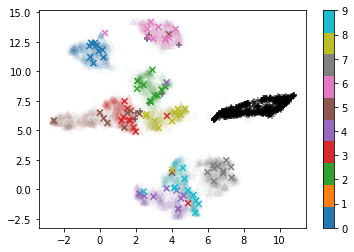

In [49]:
plt.scatter(X_umap2_train_sample[:,0], X_umap2_train_sample[:,1], 
            c=trainlabels_sample, cmap='tab10',alpha=0.02, marker='^')
plt.scatter(X_umap2_ood_sample[:,0], X_umap2_ood_sample[:,1], 
            color='black', alpha=0.5, marker='+')
plt.scatter(X_umap2_prototypes[:,0], X_umap2_prototypes[:,1], 
            c=label_prototype_tensor, cmap='tab10', alpha=0.99, marker='x')
plt.colorbar()
plt.show()

#Training parameters

In [50]:
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    fig, axes = plt.subplots(2,8,figsize=(15,3)) 
    for axis,im in zip(axes.ravel(),img):
        axis.imshow(im[0],cmap='gray')
    plt.show()

In [51]:
n_epochs = 40
r_block_in = 2 
gacc = 2
batch_size = 100
learning_rate = 0.0002
num_gpus = 1

In [52]:
#loss_func = nn.MSELoss()
loss_func = nn.BCELoss()

train_loader = DataLoader(dataset=mnist_train,
                          batch_size=batch_size,shuffle=True,drop_last=True)

#PDD Training

In [53]:
# loss function, optimizers, and labels for training
generator.train()
discriminator.train()

gen_optim = torch.optim.Adam(generator.parameters(), lr= gacc*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

optim_intra = torch.optim.Adam(discriminator.parameters(), lr=0.01*learning_rate, betas=(0.5,0.999))
optim_inter = torch.optim.Adam(discriminator.parameters(), lr=0.001*learning_rate, betas=(0.5,0.999))


ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

In [54]:
dis_loss_list = []
gen_loss_list = []

loss_reg_list = []
loss_std_list = []
loss_mean_list = []

In [ ]:
start = time.time()
for total_epoch, i in enumerate(range(n_epochs)):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(gacc*batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,torch.ones_like(dis_fake))) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,torch.zeros_like(dis_fake))) + torch.sum(loss_func(dis_real,torch.ones_like(dis_real)))
        dis_loss.backward()
        dis_optim.step()

        # Inter-class Margins
        if True: #i == 0 : # 
                  #optimizer.zero_grad()
                  optim_intra.zero_grad()

                  # Update prototype projections
                  dout_prototypes =[]
                  label_prototypes = [] 
                  for j,(image,label) in enumerate(prototype_loader):
                    dout_prototypes.append(discriminator(image)[1])
                    label_prototypes.append(label)

                  dout_prototype_tensor = torch.cat(dout_prototypes)
                  label_prototype_tensor = torch.cat(label_prototypes)
                  size_expand = torch.Size([len(dout_prototype_tensor)])+dout_prototype_tensor.size()

                  # Prototype distance matrix
                  cdist_prototypes = torch.sum((
                    dout_prototype_tensor.unsqueeze(dim=0).expand(size_expand) - \
                    dout_prototype_tensor.unsqueeze(dim=1).expand(size_expand)
                    )**2, dim=2)
                
                  # Intra-class margins
                  intra_cdist_mat = [cdist_prototypes[torch.where(label_prototype_tensor==i)[0]][:,torch.where(label_prototype_tensor==i)[0]]
                                   for i in np.unique(label_prototype_tensor)
                                   ]

                  #non-diagonal elements
                  intra_cdist_std_mean = torch.stack([torch.stack(torch.std_mean(torch.masked_select(matrix, matrix != torch.triu(matrix))))
                  for matrix in intra_cdist_mat])

                  # intra-class medians
                  intra_R_min = torch.median(intra_cdist_std_mean[:,1])
                  
                  #intra-class margin loss
                  if i % r_block_in == 0:
                    loss_intra = torch.sqrt(torch.mean(torch.masked_select((intra_cdist_std_mean[:,1] - intra_R_min)**2, intra_cdist_std_mean[:,1] > intra_R_min)))
                    loss_intra.backward()
                    optim_intra.step()
                    loss_std_list.append(loss_intra.tolist())

                  optim_inter.zero_grad()
                  
                  intra_R_max = torch.amax(intra_cdist_std_mean[:,1] + 2*intra_cdist_std_mean[:,0] )
                  intra_R_max.detach()

                  # Prototype distance matrix
                  cdist_prototypes2 = torch.sum((
                    dout_prototype_tensor.unsqueeze(dim=0).expand(size_expand) - \
                    dout_prototype_tensor.unsqueeze(dim=1).expand(size_expand)
                    )**2, dim=2)
                  # inter-class margins
                  inter_cdist_mat = [cdist_prototypes2[torch.where(label_prototype_tensor==i)[0]][:,torch.where(label_prototype_tensor==j)[0]]
                                   for i,j in combinations(np.unique(label_prototype_tensor), 2)
                                   ]


                  inter_cdist_triu = torch.cat([torch.masked_select(matrix, matrix != torch.triu(matrix)) for matrix in inter_cdist_mat])
                  # inter-class margin threshold
                  inter_R = max(inter_cdist_triu.median(), intra_R_max).detach()

                  if i % r_block_in != 0:#block
                    loss_inter = torch.sqrt(torch.mean(torch.masked_select((inter_R - inter_cdist_triu)**2, inter_cdist_triu<inter_R)))
                    loss_inter.backward()
                    optim_inter.step()
                    loss_mean_list.append(loss_inter.tolist())

                  #log intra/inter-class margin losses
                  if i > 1:
                    loss = loss_intra+loss_inter
                    loss_reg_list.append(loss.tolist())

        gen_loss_list.append(gen_loss.tolist())
        dis_loss_list.append(dis_loss.tolist())
    
    # save model every epochs
    if (i % 1 == 0):
      image_check(gen_fake.cpu())
      print('Epoch: ', total_epoch, ' ETA: ', (n_epochs - i -1)*(time.time()-start)/(i+1)/60, 'MPE: ', (time.time()-start)/(i+1)/60)
      if i != 0:
              fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,3))
              axes[0].plot(gen_loss_list,linestyle='None',marker='x',alpha=0.1,color='blue')
              axes[0].set_title('gen')
              axes[1].plot(dis_loss_list,linestyle='None',marker='.',alpha=0.1,color='orange')
              axes[1].set_title('dis')
              plt.show()
              
              model_path_g = logpath+'generator_'+str(total_epoch)+'_'+str(ood_classes[0])+'.pkl'
              model_path_d = logpath+'discriminator_'+str(total_epoch)+'_'+str(ood_classes[0])+'.pkl'
              torch.save(generator.state_dict(), model_path_g)
              torch.save(discriminator.state_dict(), model_path_d)
              print(model_path_g, model_path_d)

              fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
              axes[0].plot(np.array(loss_mean_list[:]),linestyle='None',marker='.',color='green')
              axes[0].set_title('inter')
              axes[1].plot(np.array(loss_std_list[:]),linestyle='None',marker='+',color='magenta')
              axes[1].set_title('intra')

# Learning Curves

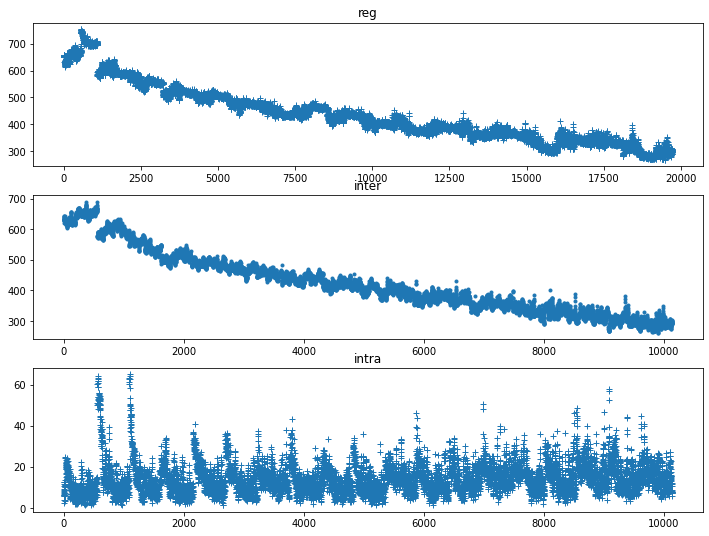

In [57]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12,9))
axes[0].plot(np.array(loss_reg_list[500:]),linestyle='None',marker='+')
axes[0].set_title('reg')

axes[1].plot(np.array(loss_mean_list[500:]),linestyle='None',marker='.')
axes[1].set_title('inter')

axes[2].plot(np.array(loss_std_list[500:]),linestyle='None',marker='+')
axes[2].set_title('intra')

plt.show()

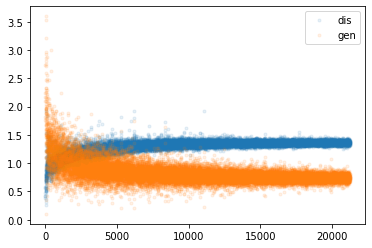

In [58]:
plt.plot(dis_loss_list[50:],marker='.',linestyle='None', alpha=0.1)
plt.plot(gen_loss_list[50:],marker='.',linestyle='None', alpha = 0.1)
plt.legend(['dis','gen'])
plt.show()

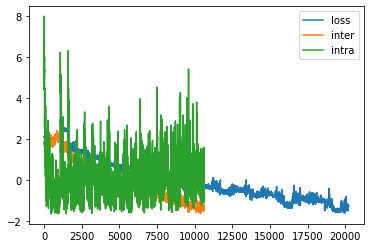

In [59]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

plt.plot(scaler.fit_transform(np.array(loss_reg_list).reshape(-1,1)))
plt.plot(scaler.fit_transform(np.array(loss_mean_list).reshape(-1,1)))
plt.plot(scaler.fit_transform(np.array(loss_std_list).reshape(-1,1)))
plt.legend(['loss','inter','intra'])
plt.show()

#Post-training Feature Extraction

In [60]:
discriminator.eval()

DataParallel(
  (module): Discriminator(
    (layer1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (layer2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (fc): Sequential(
      (0): Linear(in_features=3136, o

In [61]:
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=100,
    shuffle=False,
    drop_last=False)

In [62]:
dafter_test =[]
labels_test = [] 
start = time.time()

#for j,(image,label) in zip(range(40),test_loader):
for j,(image,label) in enumerate(test_loader):

  dafter_test.append(discriminator(image)[1])
  labels_test.extend(label.tolist())

dafter_test_array = torch.cat(dafter_test).cpu().detach().numpy()
labels_test_array = np.array(labels_test)

dafter_test_array.shape, labels_test_array.shape

CPU times: user 2.35 s, sys: 68.3 ms, total: 2.42 s
Wall time: 2.41 s


((10000, 3136), (10000,))

In [63]:
dafter_train =[]
labels_train = [] 
start = time.time()

for j,(image,label) in enumerate(train_loader):

    dafter_train.append(discriminator(image)[1])
    labels_train.extend(label.tolist())

dafter_train_array = torch.cat(dafter_train).cpu().detach().numpy()
labels_train_array = np.array(labels_train)
dafter_train_array.shape, labels_train_array.shape

CPU times: user 267 ms, sys: 5.73 ms, total: 273 ms
Wall time: 251 ms


((1000, 3136), (1000,))

In [ ]:
dafter_prototypes =[]
label_prototypes = [] 

for j,(image,label) in enumerate(prototype_loader):
  dafter_prototypes.append(discriminator(image)[1])
  label_prototypes.append(label)

dafter_prototype_tensor = torch.cat(dafter_prototypes).detach().cpu()
label_prototype_tensor = torch.cat(label_prototypes)


# Visualization - UMAP

In [65]:
dafter_train_array.shape, \
dafter_test_array.shape, \
dafter_prototype_tensor.numpy().shape

((1000, 3136), (10000, 3136), (90, 3136))

In [66]:
umap2 = UMAP()
umap2

UMAP()

In [67]:
dafter_combined_array = np.concatenate([#dafter_train_array, 
                                       dafter_test_array,
                                       dafter_prototype_tensor.numpy()])
dafter_combined_array.shape

(10090, 3136)

In [68]:
#Approx. 40 secs
%%time
umap2.fit(dafter_combined_array)

CPU times: user 34.1 s, sys: 2.12 s, total: 36.2 s
Wall time: 7.79 s


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [69]:
X_umap2_train = umap2.transform(dafter_train_array)

CPU times: user 8.06 s, sys: 287 ms, total: 8.34 s
Wall time: 6.73 s


In [70]:
%%time 
#Approx. 30secs
X_umap2_test = umap2.transform(dafter_test_array)

CPU times: user 24 s, sys: 734 ms, total: 24.7 s
Wall time: 17.3 s


In [71]:
X_umap2_prototypes = umap2.transform(dout_prototype_tensor.detach().cpu().numpy())

CPU times: user 2.71 s, sys: 18 ms, total: 2.73 s
Wall time: 2.59 s


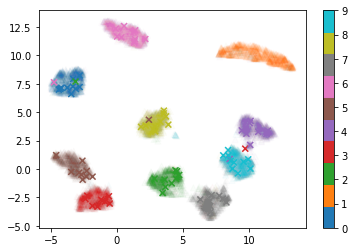

In [73]:
plt.scatter(X_umap2_test[:,0], X_umap2_test[:,1], 
            c=labels_test_array, cmap='tab10',alpha=0.02, marker='^')
plt.scatter(X_umap2_prototypes[:,0], X_umap2_prototypes[:,1], 
            c=label_prototype_tensor, cmap='tab10', alpha=0.99, marker='x')
plt.colorbar()
plt.show()

# Prototype KDE

In [74]:
bw = 10

In [75]:
scaler = MinMaxScaler()

In [76]:
umap3 = UMAP(n_components=3)

In [77]:
dafter_combined_test = np.concatenate([dafter_test_array, 
                                            dafter_prototype_tensor.detach().cpu().numpy()])
dafter_combined_test.shape

(10090, 3136)

In [78]:
%%time
#Approx. 40 sec
X_umap3_combined_test = umap3.fit(dafter_combined_test)

CPU times: user 34.4 s, sys: 1.85 s, total: 36.2 s
Wall time: 7.47 s


In [79]:
%%time
#Approx. 30 sec
X_umap3_test_after = umap3.transform(dafter_test_array)
X_umap3_prototypes_after = umap3.transform(dafter_prototype_tensor.detach().cpu().numpy())

CPU times: user 32.6 s, sys: 1.23 s, total: 33.8 s
Wall time: 24.2 s


In [80]:
model_kde = KernelDensity(bandwidth=bw)

In [81]:
model_kde_prototypes = [ KernelDensity(bandwidth=bw).fit(X_umap3_prototypes_after[np.where(np.array(label_prototype_tensor)==i)]) 
for i in np.unique(label_prototype_tensor) ] 
len(model_kde_prototypes)

9

In [82]:
score_kde_prototypes = [ model.score_samples(X_umap3_test_after) for model in model_kde_prototypes]

In [83]:
scaled_score_prototypes = [ (score - np.max(score))/(np.max(score)-np.quantile(score, 0.9)) 
for score in score_kde_prototypes]

In [85]:
score_agg = np.max(scaled_score_prototypes, axis=0) #+kde_scores_prototypes[-1]
score_agg.shape

(10000,)

## Boxplot & AUC evaluations

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


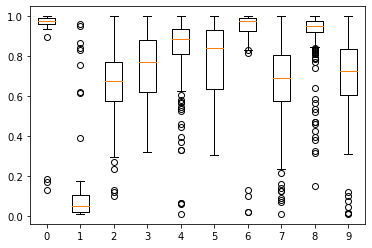

In [86]:
data = [np.exp(score_agg)[np.where(np.array(labels_test_array)==i)] for i in np.unique(labels_test_array)]

fig, axes = plt.subplots()

axes.boxplot(data, labels=np.unique(labels_test_array))

plt.show()

In [87]:
y_roc = labels_test_array == ood_classes[0]
roc_auc_score(y_roc, -score_agg)

0.9955880547915253

roc: 0.9955880547915253


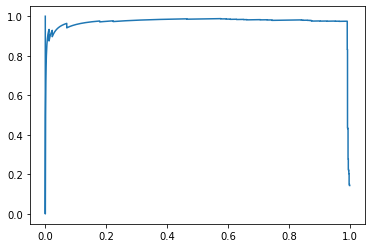

prc:  0.9696213957191433


In [88]:
y_roc = [i in ood_classes for i in labels_test_array]
print('roc:', roc_auc_score(y_roc, -score_agg)) 

pr, re, th = precision_recall_curve(y_roc,-score_agg)
plt.plot(re, pr)
plt.show()
print('prc: ', average_precision_score(y_roc, -score_agg))